In [1]:
import rospy
from geometry_msgs.msg import Point, Pose, Twist
from nav_msgs.msg import Odometry
import actionlib
from actionlib_msgs.msg import GoalStatus
from assignment_2_2023.msg import Vel, PlanningAction, PlanningGoal
import ipywidgets as widgets
from ipywidgets import VBox, HBox
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import time

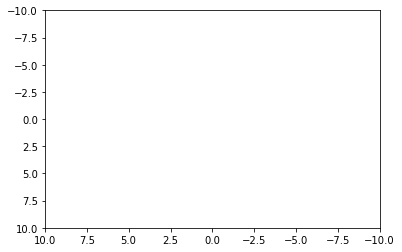

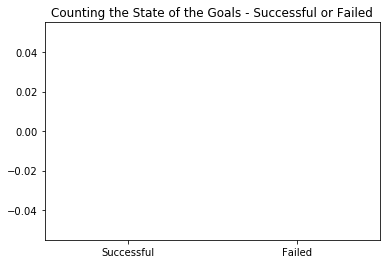

In [ ]:
class RobotGoalHandler:
    """
    Class responsible for handling robot goals and publishing position and velocity information.
    """

    def __init__(self):
        """
        Initialize the RobotGoalHandler class.
        """
        self.velocity_publisher = None
        self.action_client = None
        self.is_goal_cancelled = True
        self.target_reached = 0
        self.target_canceled = 0
        self.x_data, self.y_data = [], []
        self.n_goals = [0, 0]

        # Initialize matplotlib figure and axes
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'g^')
        self.ax.set_xlim(10, -10)
        self.ax.set_ylim(10, -10)

        # Initialize bar plot for goal status
        self.fig_goals, self.ax_goals = plt.subplots()
        self.res = ['Successful', 'Failed']
        self.bar_colors = ['tab:green', 'tab:red']
        self.bar = self.ax_goals.bar(self.res, self.n_goals, color=self.bar_colors)
        self.ax_goals.set_title('Counting the State of the Goals - Successful or Failed')

        # Initialize widgets
        self.x_goal_widget = widgets.BoundedFloatText(value=0, min=-10, max=10, description='The Position of x:', disabled=False)
        self.y_goal_widget = widgets.BoundedFloatText(value=0, min=-10, max=10, description='The Position of y:', disabled=False)
        self.send_goal_button = widgets.Button(description="Send Goal")
        self.cancel_button = widgets.Button(description="Cancel")
        self.goals_reached_label = widgets.Text(value='0', description='Successful Goals:', disabled=True)
        self.goals_canceled_label = widgets.Text(value='0', description='Canceled Goals:', disabled=True)
        self.distance_to_obstacle_label = widgets.Text(value='0.0', description='Distance to Obstacle:', disabled=True)

        # Connect button clicks to functions
        self.send_goal_button.on_click(self.send_goal)
        self.cancel_button.on_click(self.cancel_goal)

    def initialize_ros_components(self):
        """
        Initialize ROS components.

        This method initializes the ROS node and the necessary publishers and action clients for communication with the robot.

        Args:
            None

        Returns:
            None
        """
        rospy.init_node('set_robot_target_client', anonymous=True)
        self.velocity_publisher = rospy.Publisher("/pos_vel", Vel, queue_size=1)
        self.action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
        self.action_client.wait_for_server()

    def handle_goal_commands(self):
        """
        Handle user input for setting or canceling goals.

        This method continuously prompts the user for input and responds accordingly by setting new goals or canceling current goals.

        Args:
            None

        Returns:
            None
        """
        rospy.Subscriber("/odom", Odometry, self.publish_robot_position_velocity)
        display(VBox([self.x_goal_widget, self.y_goal_widget, HBox([self.send_goal_button, self.cancel_button]), self.goals_reached_label, self.goals_canceled_label, self.distance_to_obstacle_label]))
        ani = FuncAnimation(self.fig, self.update_plot, init_func=self.plot_init)
        plt.show(block=True)
        ani_goals = FuncAnimation(self.fig_goals, self.update_goals_plot)
        plt.show(block=True)

        rospy.spin()

    def send_goal(self, b):
        """
        Send a new goal for the robot.

        Args:
            b: Button click event.

        Returns:
            None
        """
        goal = PlanningGoal()
        goal.target_pose.pose.position.x = self.x_goal_widget.value
        goal.target_pose.pose.position.y = self.y_goal_widget.value

        rospy.set_param('/des_pos_x', self.x_goal_widget.value)
        rospy.set_param('/des_pos_y', self.y_goal_widget.value)

        self.action_client.send_goal(goal, done_cb=self.done_cb, active_cb=self.active_cb, feedback_cb=self.feedback_cb)
        self.is_goal_cancelled = False
        self.ax.plot(self.x_goal_widget.value, self.y_goal_widget.value, marker="+", markeredgecolor="cyan")

    def cancel_goal(self, b):
        """
        Cancel the current goal.

        Args:
            b: Button click event.

        Returns:
            None
        """
        if not self.is_goal_cancelled:
            self.action_client.cancel_goal()
            rospy.loginfo("Current goal has been cancelled")
            self.is_goal_cancelled = True
            self.target_canceled += 1
            self.update_goals_plot()
        else:
            rospy.loginfo("No active goal to cancel")

    def publish_robot_position_velocity(self, message):
        """
        Publish the robot's position and velocity information.

        This method receives odometry data from the robot and publishes its current position and velocity.

        Args:
            message (Odometry): The odometry message containing position and velocity data.

        Returns:
            None
        """
        current_pos = message.pose.pose.position
        current_vel_linear = message.twist.twist.linear
        current_vel_angular = message.twist.twist.angular
        pos_and_vel = Vel()
        pos_and_vel.pos_x = current_pos.x
        pos_and_vel.pos_y = current_pos.y
        pos_and_vel.vel_x = current_vel_linear.x
        pos_and_vel.vel_z = current_vel_angular.z
        self.velocity_publisher.publish(pos_and_vel)

        self.x_data.append(current_pos.x)
        self.y_data.append(current_pos.y)

        if self.action_client.get_state() == GoalStatus.SUCCEEDED:
            self.target_reached += 1
            self.update_goals_plot()

    def plot_init(self):
        self.ax.set_xlim(10, -10)
        self.ax.set_ylim(10, -10)
        return self.ln

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

    def update_goals_plot(self, frame=None):
        self.n_goals = [self.target_reached, self.target_canceled]
        for bar, height in zip(self.bar, self.n_goals):
            bar.set_height(height)
        plt.draw()

    def done_cb(self, status, result):
        if status == GoalStatus.SUCCEEDED:
            rospy.loginfo("Goal succeeded!")
            self.target_reached += 1
        elif status in [GoalStatus.PREEMPTED, GoalStatus.RECALLED, GoalStatus.REJECTED, GoalStatus.ABORTED]:
            rospy.loginfo("Goal failed or was cancelled!")
            self.target_canceled += 1
        self.update_goals_plot()

    def active_cb(self):
        rospy.loginfo("Goal is now being processed by the action server.")

    def feedback_cb(self, feedback):
        rospy.loginfo(f"Feedback received: x = {feedback.base_position.pose.position.x}, y = {feedback.base_position.pose.position.y}")

def main():
    """
    Main function to initialize and run the RobotGoalHandler.
    
    This function creates an instance of RobotGoalHandler, initializes ROS components, and starts handling goal commands.

    Args:
        None

    Returns:
        None
    """
    robot_handler = RobotGoalHandler()
    robot_handler.initialize_ros_components()
    robot_handler.handle_goal_commands()

if __name__ == '__main__':
    main()
